In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, "../")
import sys; sys.path.insert(0, "../inverse_parametric_burgers/")

import numpy as np
from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pickle_load("../parametric_pde_data/parametric_advection_diffusion.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

# Exact = data['u']
Exact = data['u'].T

X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

L = 5
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L)
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(spatial_dims)

Loaded from ../parametric_pde_data/parametric_advection_diffusion.pkl


In [3]:
pinn = ParametricPINN(n_funcs=0, scale=True, lb=lb, ub=ub)
# print("Loaded the pretrained weights")
# pinn.load_state_dict(torch.load("..."))

You are not using the parametric_func_net


In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = pinn.loss(*dimension_slicing(X_train), u_train)
    loss = mse_loss
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [6]:
# optimizer = MADGRAD(pinn.parameters(), lr=1e-3, momentum=0.9)
# for i in range(150):
#     pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0:
#         loss = pcgrad_closure(return_list=True)
#         print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=300, max_eval=int(1.25*300), history_size=300, line_search_fn='strong_wolfe')
for i in range(100):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

0.020607205107808113
7.5448924690135755e-06
6.619018222409068e-06
4.077708126715152e-06
3.7389509088825434e-06
3.4926592888950836e-06
3.4679285363381496e-06
3.234907126170583e-06
2.996670446009375e-06
2.992350573549629e-06


In [23]:
F.mse_loss(pinn(*dimension_slicing(X_star))[0], u_star)

tensor(3.0794e-06, grad_fn=<MseLossBackward>)

In [24]:
grads_dict = pinn.gradients_dict(*dimension_slicing(X_star))

feature_names = list(grads_dict.keys())
print(feature_names)
u_t_index = feature_names.index('u_t')

referenced_derivatives = np.hstack([t.detach().numpy() for t in list(grads_dict.values())])
u_t = referenced_derivatives[:, u_t_index:u_t_index+1]

referenced_derivatives = np.delete(referenced_derivatives, u_t_index, 1)
del feature_names[u_t_index]

['u', 'u_t', 'u_x', 'u_xx']


In [25]:
xx, tt = dimension_slicing(X_star)
pred_Exact, _ = pinn(xx, tt)
pred_Exact = pred_Exact.reshape(X.shape)

pred_Exact = to_numpy(pred_Exact)
Z, E1 = RobustPCA(pred_Exact, lam_2=0.1)

# rpca = R_pca(pred_Exact, verbose=True)
# Z, E1 = rpca(max_iter=200, iter_print=100)

Z = to_column_vector(Z)
# Use Z instead
referenced_derivatives[:, 0:1] = Z

Please ensure that the shape of U is correct.
iteration:1, err:1470.135138329204, nc_norm:385.8056582273569 eta1:0.011908096275171748
iteration:50, err:0.1367343340120503, nc_norm:435.11094557769457 eta1:1.270819616287218
iteration:100, err:0.0014637184117628598, nc_norm:216.2078253162407 eta1:149.18259861220426
iteration:150, err:4.825465435374566e-05, nc_norm:214.35015513292691 eta1:17512.67248589598
iteration:170, err:9.114801111539484e-06, nc_norm:214.33698169589096 eta1:117816.50326142123


In [26]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Theta = poly.fit_transform(referenced_derivatives)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [27]:
# Theta_grouped, Ut_grouped = create_groups(Theta, u_t, spatial_dims, time_dims)

In [28]:
xi, X, E2 = DLrSR(Theta_grouped, u_t.reshape(X.shape), d_tol=50)

iteration:1, err:6108.39010326899, nc_norm:1700.4059355563247 eta2:0.0031251396797939866
iteration:50, err:0.022825942846055942, nc_norm:957.252736379389 eta2:23.700116971735547
iteration:100, err:1.4121000401720807e-05, nc_norm:944.53353816653 eta2:215681.44864909528
iteration:116, err:9.241764523373012e-07, nc_norm:944.5323767744118 eta2:3987610.4790895805
IALM Finished at iteration 116


/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ad/../parametric_pde_diff.py:602: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ad/../parametric_pde_diff.py:572: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


In [29]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

0 -> u
1 -> u_x
2 -> u_xx


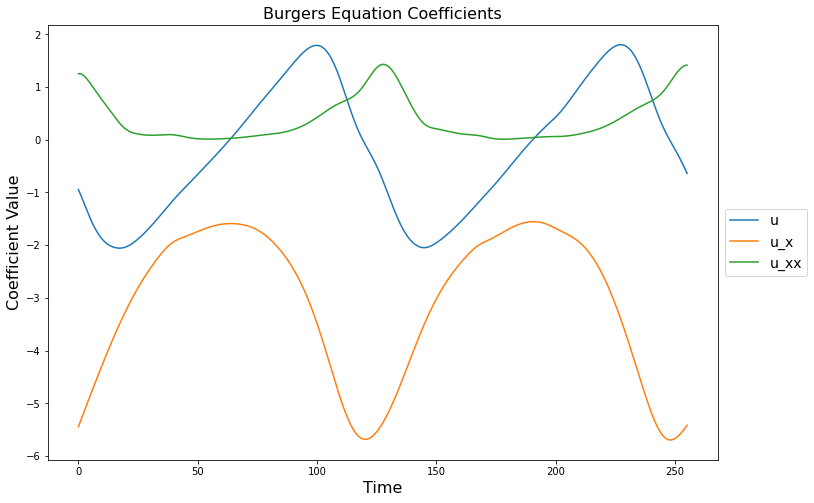

In [30]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, '->', poly_feature_names[j])
        plot(xi[j,:], label = poly_feature_names[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)